# Week 8 Presentation 7: CNN Case 4 Example
Note: this is the version of my Week 8 work with many of the comments removed for readability. I wanted to keep the script clean and clear. The alternative version of the notebook contains comments explaining parameter selection, function selection, and other definitions/explanations/checks.

Also, the following was run using Python 3 in Google Colab with GPU.


# Load Necessary Libraries

In [37]:
# quiet output
%%capture

%%javascript
document.querySelectorAll('.output_scroll').forEach(el => {
    el.classList.remove('output_scroll');
});

# install missing libraries
!pip install torch torchvision
!pip install lightning

# LOAD LIBRARIES

# to create tensors to store all numerical values (eg. raw data, weight, bias)
import torch

# to make the weight and bias tensors part of the neural network
import torch.nn as nn

# for the activation functions; to help move data forward
import torch.nn.functional as F

# Stochastic Gradient Descent to fit neural net to the data
#from torch.optim import SGD

# better for working with large datasets
from torch.utils.data import DataLoader, TensorDataset, Dataset

# to make training easier to code
import lightning as L
from lightning.pytorch import Trainer

# for graphing output
import matplotlib.pyplot as plt
import seaborn as sns

# for model evaluation
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import f1_score

# Data PreProcessing

In [38]:
# Recreate Example Images as 4D Tensors
# Expected 4D shape: (1 batch, 1 channel, 6x6 image)

# Case 1
O_image = torch.tensor([[0, 0, 1, 1, 0, 0],
                        [0, 1, 0, 0, 1, 0],
                        [1, 0, 0, 0, 0, 1],
                        [1, 0, 0, 0, 0, 1],
                        [0, 1, 0, 0, 1, 0],
                        [0, 0, 1, 1, 0, 0]],
                       dtype=torch.float32).unsqueeze(0)

X_image = torch.tensor([[1, 0, 0, 0, 0, 1],
                        [0, 1, 0, 0, 1, 0],
                        [0, 0, 1, 1, 0, 0],
                        [0, 0, 1, 1, 0, 0],
                        [0, 1, 0, 0, 1, 0],
                        [1, 0, 0, 0, 0, 1]],
                       dtype=torch.float32).unsqueeze(0)

# Case 2
O_image_shifted = torch.tensor([[0, 1, 1, 0, 0, 0],
                                [1, 0, 0, 1, 0, 0],
                                [0, 0, 0, 0, 1, 0],
                                [0, 0, 0, 0, 1, 0],
                                [1, 0, 0, 1, 0, 0],
                                [0, 1, 1, 0, 0, 0]],
                               dtype=torch.float32).unsqueeze(0)

X_image_shifted = torch.tensor([[0, 1, 0, 0, 0, 0],
                                [0, 0, 1, 0, 0, 1],
                                [0, 0, 0, 1, 1, 0],
                                [0, 0, 0, 1, 1, 0],
                                [0, 0, 1, 0, 0, 1],
                                [0, 1, 0, 0, 0, 0]],
                               dtype=torch.float32).unsqueeze(0)



#### Create Training Data Set

In [39]:
# Create an Images Tensor by Stacking
# expected shape: (4, 1, 6, 6)
images = torch.stack([O_image, X_image, O_image_shifted, X_image_shifted], dim=0)

# Create Ground Truth Labels
# 1 = X
# 0 = O
# expected shape: (4,)
labels = torch.tensor([0, 1, 0, 1], dtype=torch.long)

In [40]:
# Use Case 1 and Case 2 Examples as Training Data

train_dataset = TensorDataset(images, labels)

train_dataloader = DataLoader(train_dataset, batch_size = 2, shuffle=True)

# Check DataLoader
# Expected Images Shape: (batch_size, 1, 6, 6)
# Expected Labels Shape: (batch_size,)
for batch_images, batch_labels in train_dataloader:
    print("Batch Images Shape:", batch_images.shape)
    print("Batch Labels Shape:", batch_labels.shape)
    break


Batch Images Shape: torch.Size([2, 1, 6, 6])
Batch Labels Shape: torch.Size([2])


#### Cases 3 and 4

In [41]:
# Case 3
padding_O1 = torch.tensor([
    [0,0,0,0,0,0,0,0,0],
    [0,0,0,0,0,0,0,0,0],
    [0,0,0,0,0,0,0,0,0],
    [0,0,1,1,0,0,0,0,0],
    [0,1,0,0,1,0,0,0,0],
    [1,0,0,0,0,1,0,0,0],
    [1,0,0,0,0,1,0,0,0],
    [0,1,0,0,1,0,0,0,0],
    [0,0,1,1,0,0,0,0,0]],
                dtype=torch.float32).unsqueeze(0)

padding_X1 = torch.tensor([
    [0,0,1,0,0,0,0,1],
    [0,0,0,1,0,0,1,0],
    [0,0,0,0,1,1,0,0],
    [0,0,0,0,1,1,0,0],
    [0,0,0,1,0,0,1,0],
    [0,0,1,0,0,0,0,1],
    [0,0,0,0,0,0,0,0],
    [0,0,0,0,0,0,0,0],
    [0,0,0,0,0,0,0,0]
    ],
                dtype=torch.float32).unsqueeze(0)

padding_O2 = torch.tensor([
    [0,0,0,0,0,0,0,0,0,0,0,0],
    [0,0,0,0,0,0,0,0,0,0,0,0],
    [0,0,0,0,0,0,0,0,0,0,0,0],
    [0,0,0,0,0,0,0,0,0,0,0,0],
    [0,0,0,0,0,0,0,0,0,0,0,0],
    [0,0,0,0,0,0,0,0,0,0,0,0],
    [0,0,1,1,0,0,0,0,0,0,0,0],
    [0,1,0,0,1,0,0,0,0,0,0,0],
    [1,0,0,0,0,1,0,0,0,0,0,0],
    [1,0,0,0,0,1,0,0,0,0,0,0],
    [0,1,0,0,1,0,0,0,0,0,0,0],
    [0,0,1,1,0,0,0,0,0,0,0,0]],
                dtype=torch.float32).unsqueeze(0)


padding_X2 = torch.tensor([
    [0,0,0,0,0,1,0,0,0,0,1],
    [0,0,0,0,0,0,1,0,0,1,0],
    [0,0,0,0,0,0,0,1,1,0,0],
    [0,0,0,0,0,0,0,1,1,0,0],
    [0,0,0,0,0,0,1,0,0,1,0],
    [0,0,0,0,0,1,0,0,0,0,1],
    [0,0,0,0,0,0,0,0,0,0,0],
    [0,0,0,0,0,0,0,0,0,0,0],
    [0,0,0,0,0,0,0,0,0,0,0],
    [0,0,0,0,0,0,0,0,0,0,0],
    [0,0,0,0,0,0,0,0,0,0,0],
    [0,0,0,0,0,0,0,0,0,0,0]
    ],
                dtype=torch.float32).unsqueeze(0)

padding_O3 = torch.tensor([
    [0,0,0,1,1,0,0,0],
    [0,0,0,1,1,0,0,0],
    [0,0,1,0,0,1,0,0],
    [1,1,0,0,0,0,1,1],
    [1,1,0,0,0,0,1,1],
    [0,0,0,1,1,0,0,0],
    [0,0,0,1,1,0,0,0]
    ],
                dtype=torch.float32).unsqueeze(0)



In [42]:
# Case 4
pattern_12x12 = torch.tensor([
    [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0],
    [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1],
    [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1],
    [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0],
    [0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
    [1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
    [1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
    [0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0]],
                             dtype=torch.float32).unsqueeze(0)

pattern_18x18 = torch.tensor([
    [0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0],
    [0,0,0,1,1,0,0,0,0,1,0,0,1,0,0,0,0,0],
    [0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0],
    [0,1,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0],
    [0,1,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0],
    [0,0,1,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0],
    [0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0],
    [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
    [0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
    [0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0],
    [1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0],
    [1,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0],
    [0,1,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0],
    [0,0,1,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0],
    [0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0],
    [0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0],
    [0,0,0,0,0,1,1,0,0,0,0,1,1,0,0,0,0,0],
    [0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0]],
                             dtype=torch.float32).unsqueeze(0)

pattern_24x24 = torch.tensor([
    [0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,1],
    [0,0,0,1,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,1,0],
    [0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,1,0,0],
    [0,1,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0],
    [0,1,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0],
    [0,0,1,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0],
    [0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0],
    [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1],
    [0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1],
    [0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0],
    [1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0],
    [1,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,1,1,0,0,0,0,0],
    [0,1,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0],
    [0,0,1,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0],
    [0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0],
    [0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,1,0,0],
    [0,0,0,0,0,1,1,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,1,0],
    [0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1],
    [0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1],
    [0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0],
    [0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,1,1,0,0],
    [1,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0],
    [0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0],
    [0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0]],
                             dtype=torch.float32).unsqueeze(0)


# Define Model With Adaptive Pooling

In [43]:
# Adaptive pooling to resize images to a fixed size
class AdaptivePoolingModel(L.LightningModule):

    def __init__(self):
        super().__init__()

        # Store losses during training
        self.training_losses = []


        # Convolutional layers
        self.conv1 = nn.Conv2d(in_channels = 1, out_channels=4,
                               kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels = 4, out_channels = 8,
                               kernel_size=3, stride=1, padding=1)


        # Adaptive Pooling layer
        # 4x4 standard size
        self.adaptive_pool = nn.AdaptiveAvgPool2d(output_size=(4, 4))


        # Fully Connected Layers
        # input features --> 64 units in hidden layer
        self.input_to_hidden = nn.Linear(8 * 4 * 4, 64)

        # unit from hidden layer --> 2 unit output layer
        self.hidden_to_output = nn.Linear(64, 2)


        # Initialize predefined 4D filter for conv1
        predefined_kernel = torch.tensor(
        [[[
          [0, 0, 1],
          [0, 1, 0],
          [1, 0, 0]
          ]]], dtype=torch.float32
        )

        # Assign the predefined kernel to the first filter in conv1
        with torch.no_grad():
          self.conv1.weight[0] = predefined_kernel



    def forward(self, x):
      # ReLU function will introduce nonlinearity

      # Extract Edges (4 lower level features)
      x = self.conv1(x)
      x = torch.relu(x)

      # Extract 8 higher level features
      x = self.conv2(x)
      x = torch.relu(x)

      # Reduce feature maps regardless of input size to 4x4
      x = self.adaptive_pool(x)

      # Flatten to 1D vector (batch_size, 128)
      x = torch.flatten(x, start_dim=1)


      # Pass from input to hidden layer
      # 128 features --> 64 hidden units
      x = self.input_to_hidden(x)
      x = torch.relu(x)

      # Pass from hidden to output layer
      # 64 hidden units --> 2 output logits ("O" and "X")
      x = self.hidden_to_output(x)


      # Output vector of size (batch_size, 2) containing raw logits
      return x



    def training_step(self, batch, batch_idx):
        images, labels = batch
        # generate predictions
        predictions = self(images)

        # alternative choice: BCE Loss
        loss = nn.CrossEntropyLoss()(predictions, labels)
        self.log('train_loss', loss)

        # store losses to graph later
        self.training_losses.append(loss.item())

        return loss


    def configure_optimizers(self):
        # can adjust the learning rate here
        return torch.optim.Adam(self.parameters(), lr=.001)



In [44]:
# Update the model to allow for feature map extraction
class AdaptivePoolingModelWithHooks(AdaptivePoolingModel):
    def __init__(self):
        super().__init__()
        self.feature_maps = {}

    def hook_layers(self):
        # Register hooks for intermediate layers
        self.conv1.register_forward_hook(self.save_feature_map('conv1'))
        self.conv2.register_forward_hook(self.save_feature_map('conv2'))
        self.adaptive_pool.register_forward_hook(self.save_feature_map('adaptive_pool'))

    def save_feature_map(self, layer_name):
        # Save the feature maps after a specific layer
        def hook(module, input, output):
            self.feature_maps[layer_name] = output
        return hook


# Train Model

INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.callbacks.model_summary:
  | Name             | Type              | Params | Mode 
---------------------------------------------------------------
0 | conv1            | Conv2d            | 40     | train
1 | conv2            | Conv2d            | 296    | train
2 | adaptive_pool    | AdaptiveAvgPool2d | 0      | train
3 | input_to_hidden  | Linear            | 8.3 K  | train
4 | hidden_to_output | Linear            | 130    | train
---------------------------------------------------------------
8.7 K     Trainable params
0         Non-trainable params
8.7 K     Total params
0.035     Total estimated model params size (MB)
5         Modules in train mode
0         Modules in eval mode
/usr/local/lib/python3.10/dist-packages/lig

Training: |          | 0/? [00:00<?, ?it/s]

INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=50` reached.


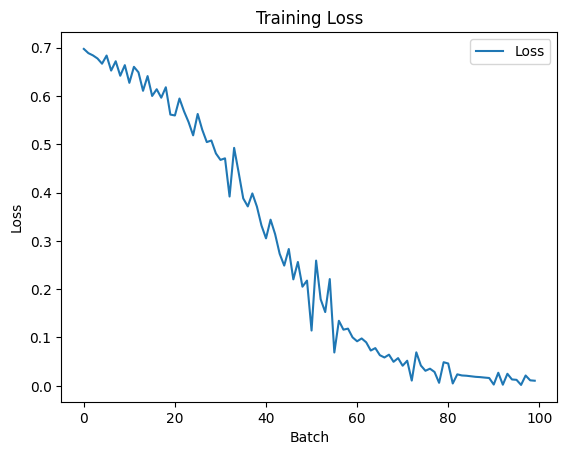

In [45]:
# Set seed for reproducability
torch.manual_seed(42)

# Initialize the model and attach hooks
model = AdaptivePoolingModelWithHooks()
model.hook_layers()

# Train the model using DataLoader
# played around with these params
trainer = Trainer(max_epochs=50, log_every_n_steps=5)
trainer.fit(model, train_dataloader)

# Plot the loss trend
plt.plot(range(len(model.training_losses)),
         model.training_losses, label="Loss")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.legend()
plt.show()

# ran out of credtits to use GPU


# Evaluate Model Performance

#### Helper Functions

In [46]:
def evaluate_model(model, dataloader):
    model.eval()
    correct = 0
    total = 0
    all_labels = []
    all_predictions = []

    # no gradients here
    with torch.no_grad():
        for images, labels in dataloader:
            # Predictions are based on class scores rather than a fixed threshold.
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)

            # Accumulate correct predictions
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # Save labels and predictions for F1 Score calculation
            all_labels.extend(labels.tolist())
            all_predictions.extend(predicted.tolist())

    # Calculate accuracy
    accuracy = 100 * correct / total

    # Calculate F1 Score
    f1 = f1_score(all_labels, all_predictions, average='weighted')  # 'weighted' accounts for class imbalance

    # Print results
    print(f"Accuracy: {accuracy:.2f}%")
    print(f"F1 Score: {f1:.2f}")


# another helper function for evaluation - conf matrix
def evaluate_confusion_matrix(model, dataloader):
    all_labels = []
    all_predictions = []

    model.eval()
    with torch.no_grad():
        for images, labels in dataloader:
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            all_labels.extend(labels.tolist())
            all_predictions.extend(predicted.tolist())

    # Generate confusion matrix
    cm = confusion_matrix(all_labels, all_predictions)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["O", "X"])
    disp.plot(cmap="Blues")
    plt.show()


# Helper to visualize feature maps from a specific layer.
def plot_feature_maps(feature_maps, layer_name, image_size):

    num_maps = feature_maps.shape[1]  # Number of feature maps
    plt.figure(figsize=(15, 15))
    for i in range(num_maps):
        plt.subplot(1, num_maps, i + 1)
        plt.imshow(feature_maps[0, i].detach().cpu().numpy(), cmap='viridis')
        plt.axis('off')
        plt.title(f"Feature {i+1}")
    plt.suptitle(f"Feature Maps from {layer_name} for {image_size} Input", fontsize=16)
    plt.show()


#### Evaluate on Training

Accuracy: 100.00%
F1 Score: 1.00


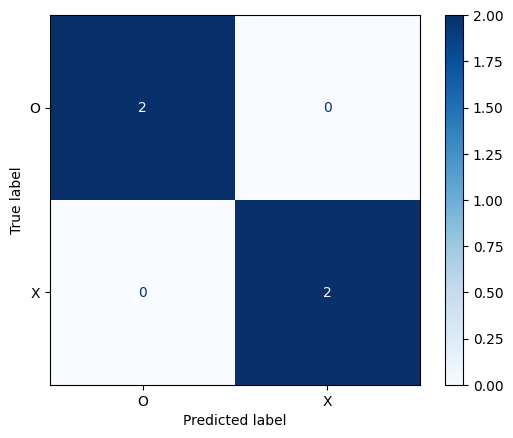

In [47]:
# Evaluate model performance on the "training data" (case 1 and 2)
evaluate_model(model, train_dataloader)
evaluate_confusion_matrix(model, train_dataloader)

#### Evaluate on Case 4 Data

In [48]:
# helper function to pass in different sizes bc can't stack
class VariableSizeDataset(Dataset):
    def __init__(self, images, labels):
        self.images = images
        self.labels = labels

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        return self.images[idx], self.labels[idx]

# the sample images
test_images = [pattern_12x12, pattern_18x18, pattern_24x24]
test_image_sizes = ['12x12', '18x18', '24x24']

# the ground truth labels
test_labels = [0, 0, 0]

# dataset
test_dataset = VariableSizeDataset(test_images, test_labels)

# data loader
# batch size 1 so each gets done
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)

# check we are passing in diff sized images
for batch_images, batch_labels in test_dataloader:
    print("Batch Image Shape:", batch_images[0].shape)
    print("Batch Label:", batch_labels)



Batch Image Shape: torch.Size([1, 12, 12])
Batch Label: tensor([0])
Batch Image Shape: torch.Size([1, 18, 18])
Batch Label: tensor([0])
Batch Image Shape: torch.Size([1, 24, 24])
Batch Label: tensor([0])


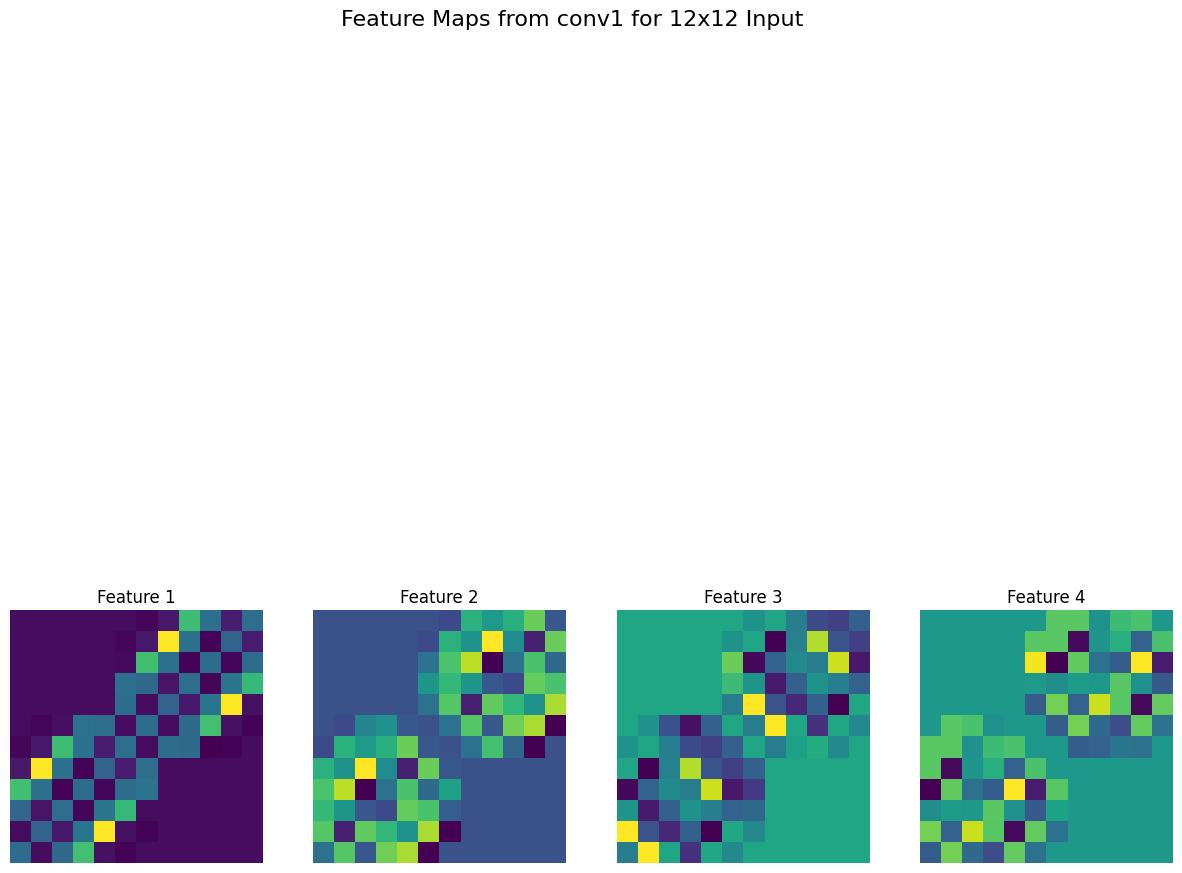

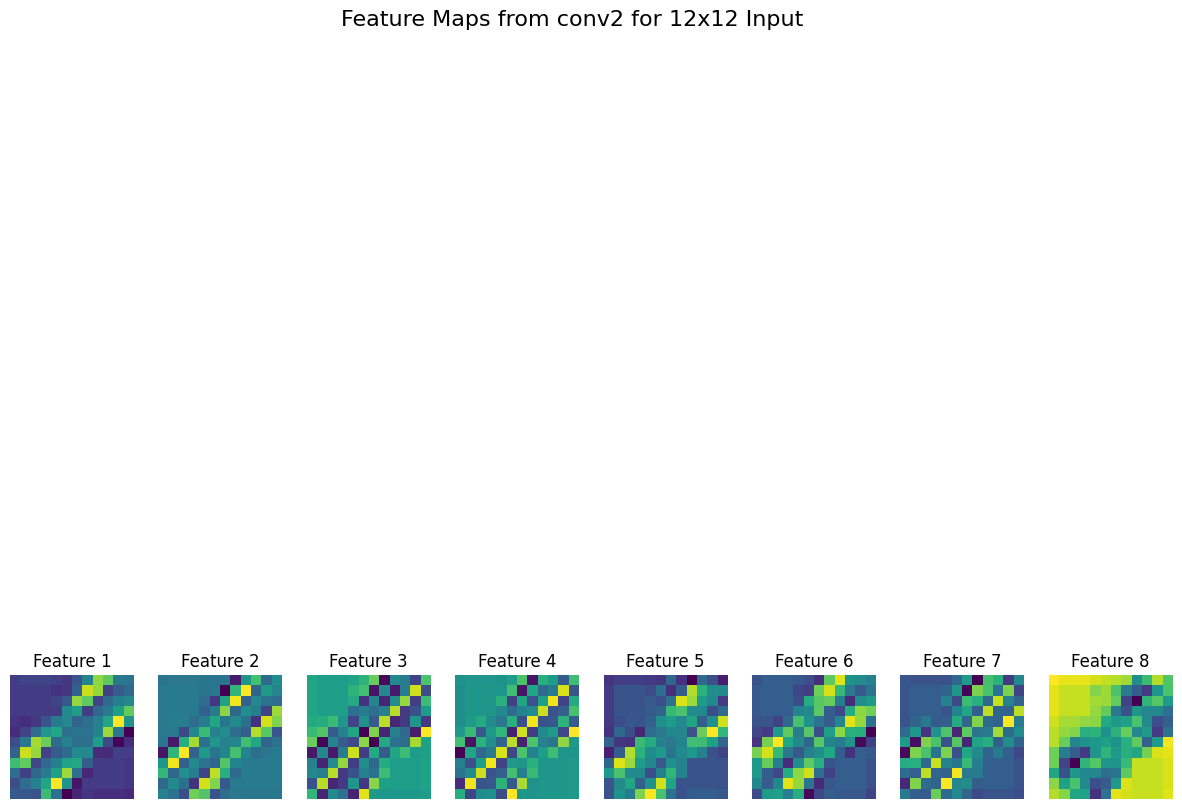

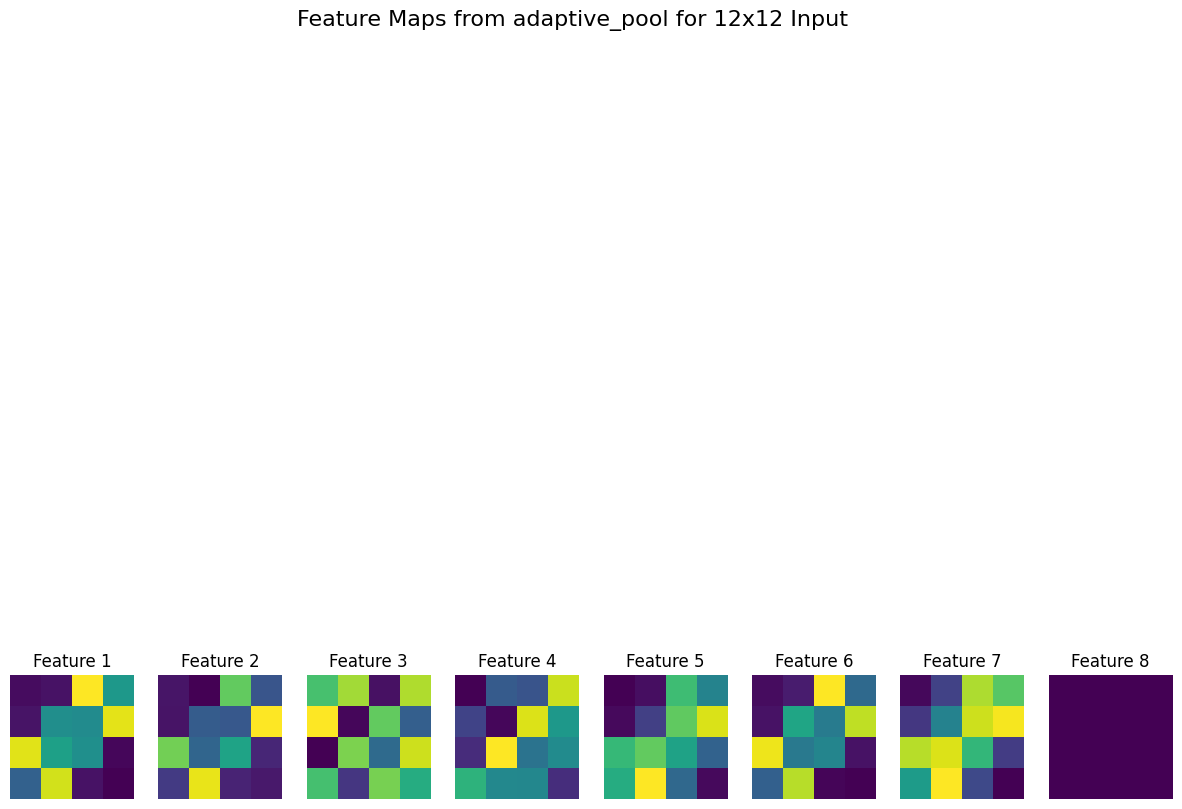

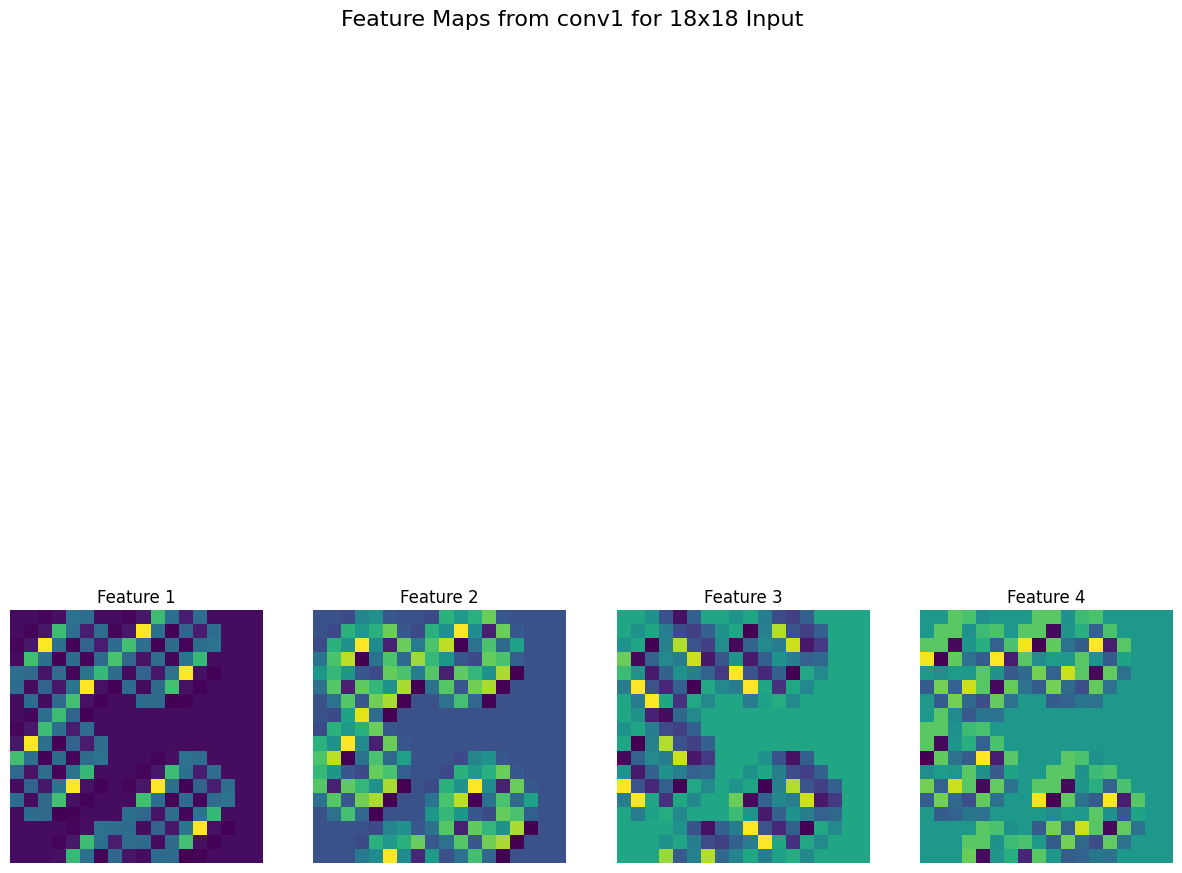

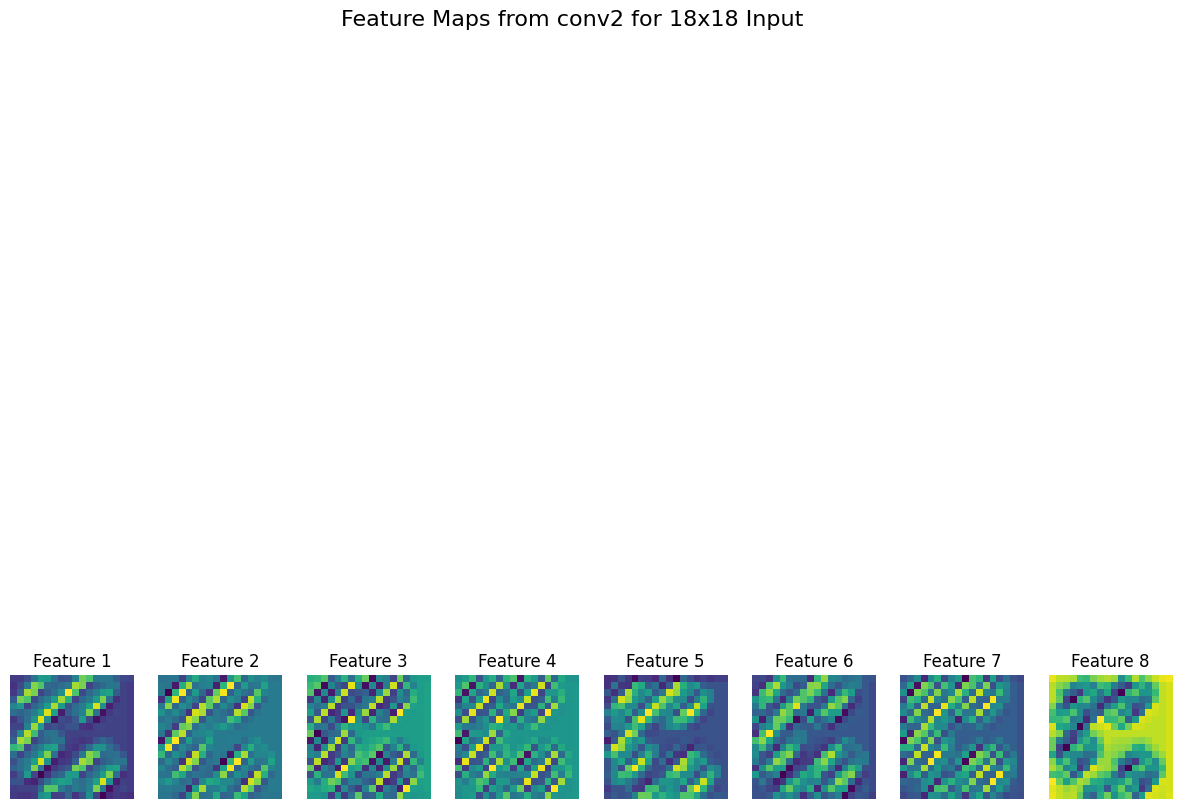

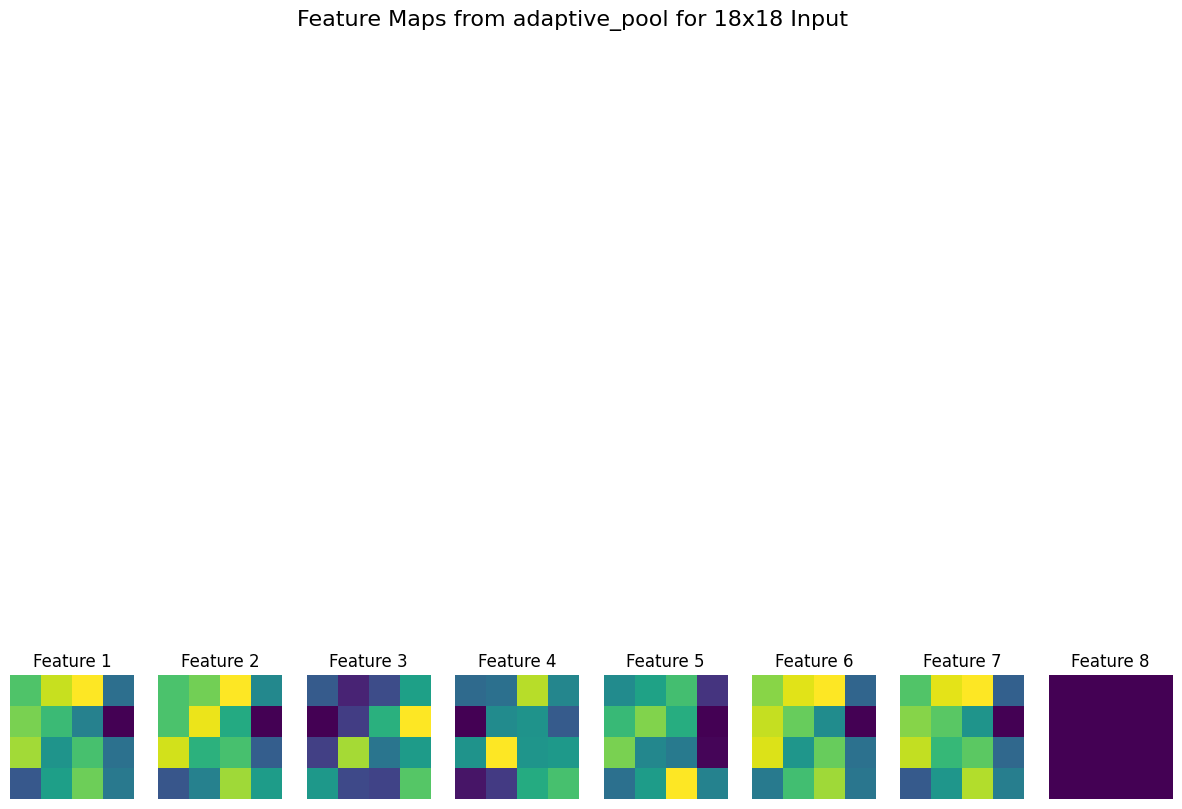

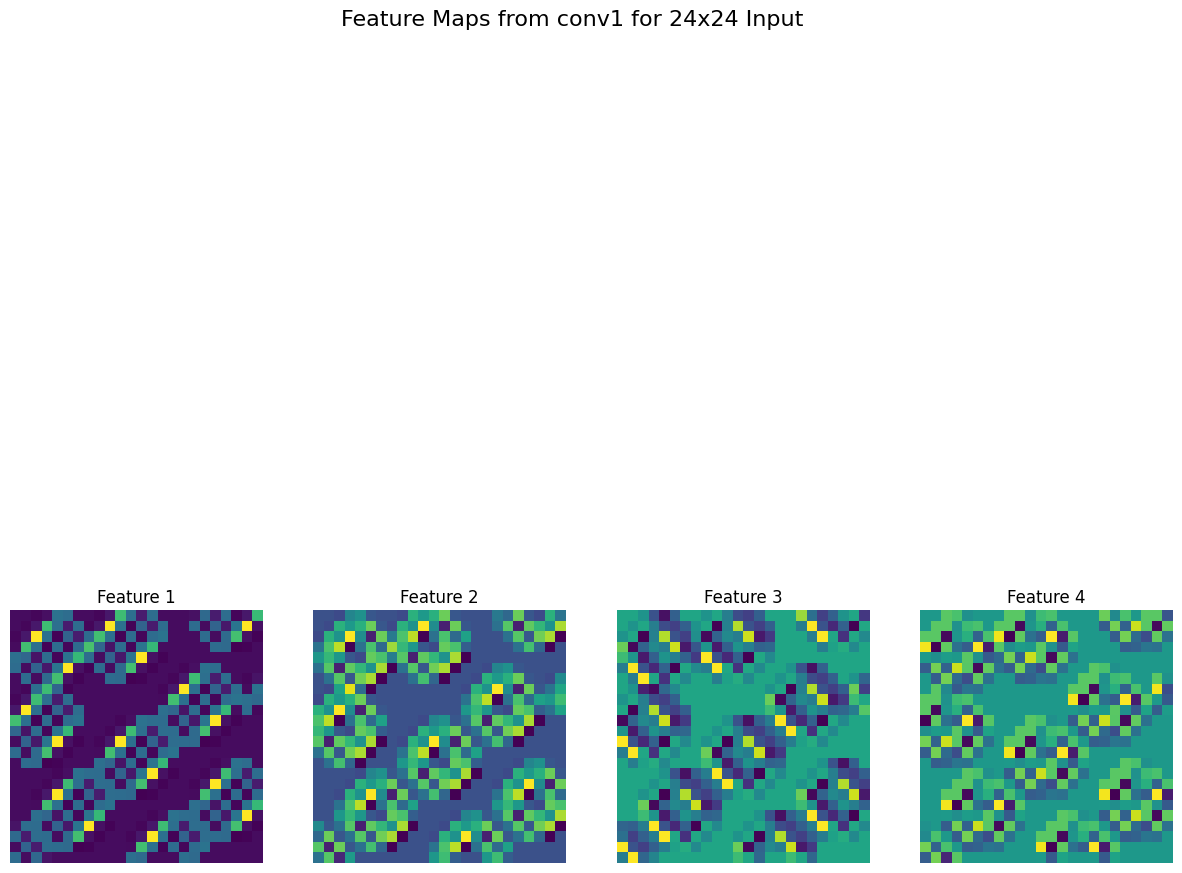

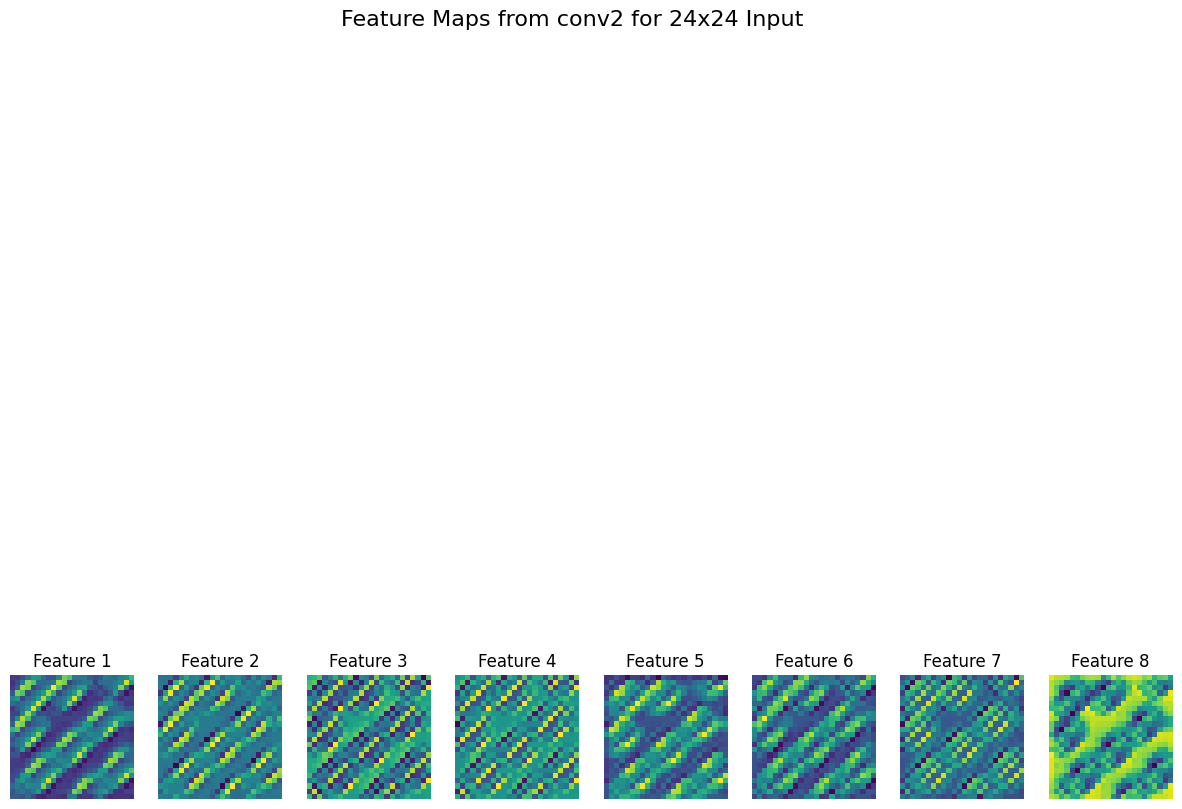

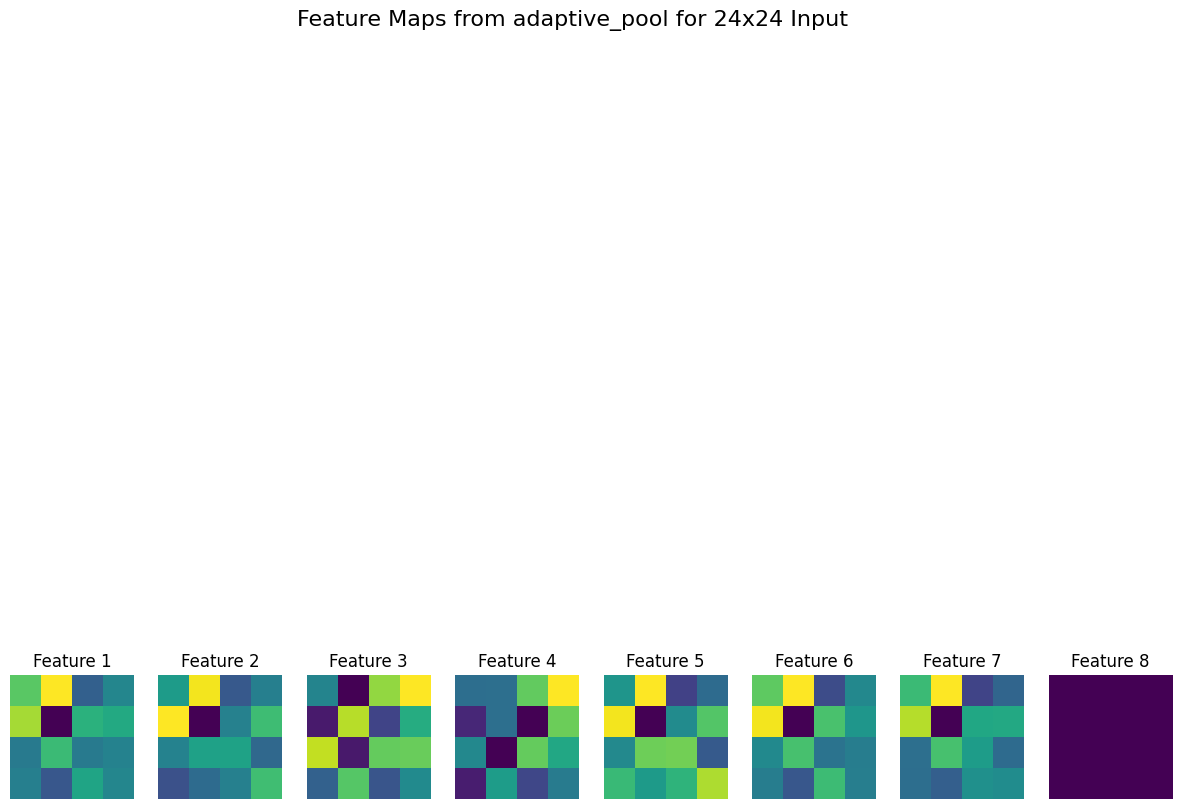

In [49]:
# Visualize feature maps (intermediate results)

for image, size in zip(test_images, test_image_sizes):
    _ = model(image.unsqueeze(0))  # Forward pass
    for layer in ['conv1', 'conv2', 'adaptive_pool']:
        plot_feature_maps(model.feature_maps[layer], layer, size)


Label: tensor([0]), Prediction: tensor([1])
Label: tensor([0]), Prediction: tensor([0])
Label: tensor([0]), Prediction: tensor([0])
Accuracy: 66.67%
F1 Score: 0.80


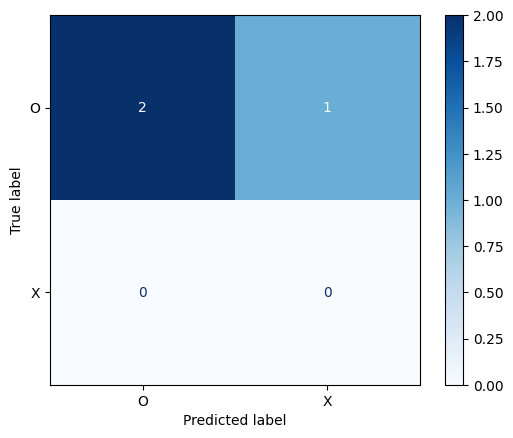

In [50]:
# perform evaluation
model.eval()
with torch.no_grad():
    for image, label in test_dataloader:
        output = model(image)
        prediction = torch.argmax(output, dim=1)
        print(f"Label: {label}, Prediction: {prediction}")

# results show in order: 12x12, 18x18, 24x24
evaluate_model(model, test_dataloader)
evaluate_confusion_matrix(model, test_dataloader)


#### Evaluate on Case 3 Data

In [51]:
# the sample images
test_images = [padding_O1, padding_X1, padding_O2, padding_X2, padding_O3]
test_image_names = ["O Padded 9x9", "X Padded 9x8", "O Padded 12x12", "X Padded 12x11", "O Padded 7x8"]

# the ground truth labels
test_labels = [0, 1, 0, 1, 0]

# dataset
test_dataset = VariableSizeDataset(test_images, test_labels)

# data loader
# batch size 1 so each gets done
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)

# check we are passing in diff sized images
for batch_images, batch_labels in test_dataloader:
    print("Batch Image Shape:", batch_images[0].shape)
    print("Batch Label:", batch_labels)

Batch Image Shape: torch.Size([1, 9, 9])
Batch Label: tensor([0])
Batch Image Shape: torch.Size([1, 9, 8])
Batch Label: tensor([1])
Batch Image Shape: torch.Size([1, 12, 12])
Batch Label: tensor([0])
Batch Image Shape: torch.Size([1, 12, 11])
Batch Label: tensor([1])
Batch Image Shape: torch.Size([1, 7, 8])
Batch Label: tensor([0])


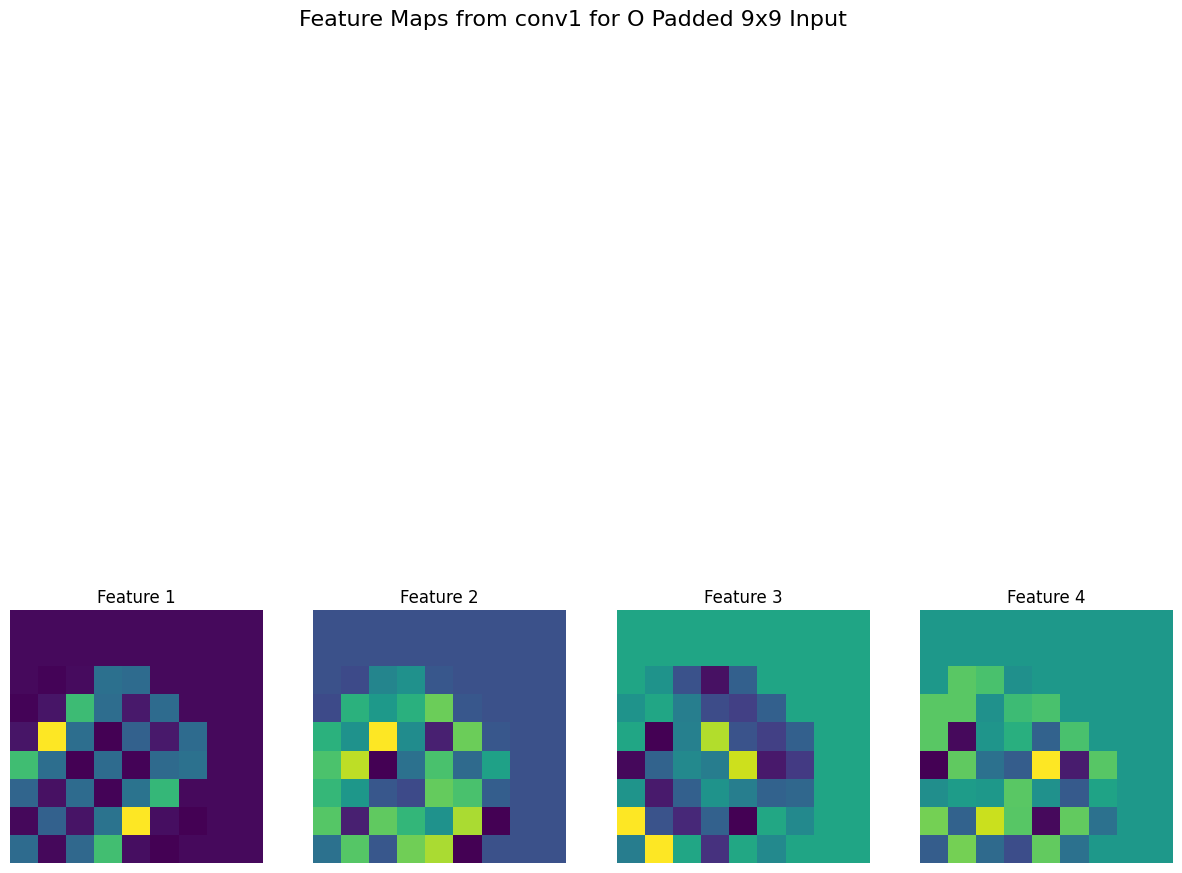

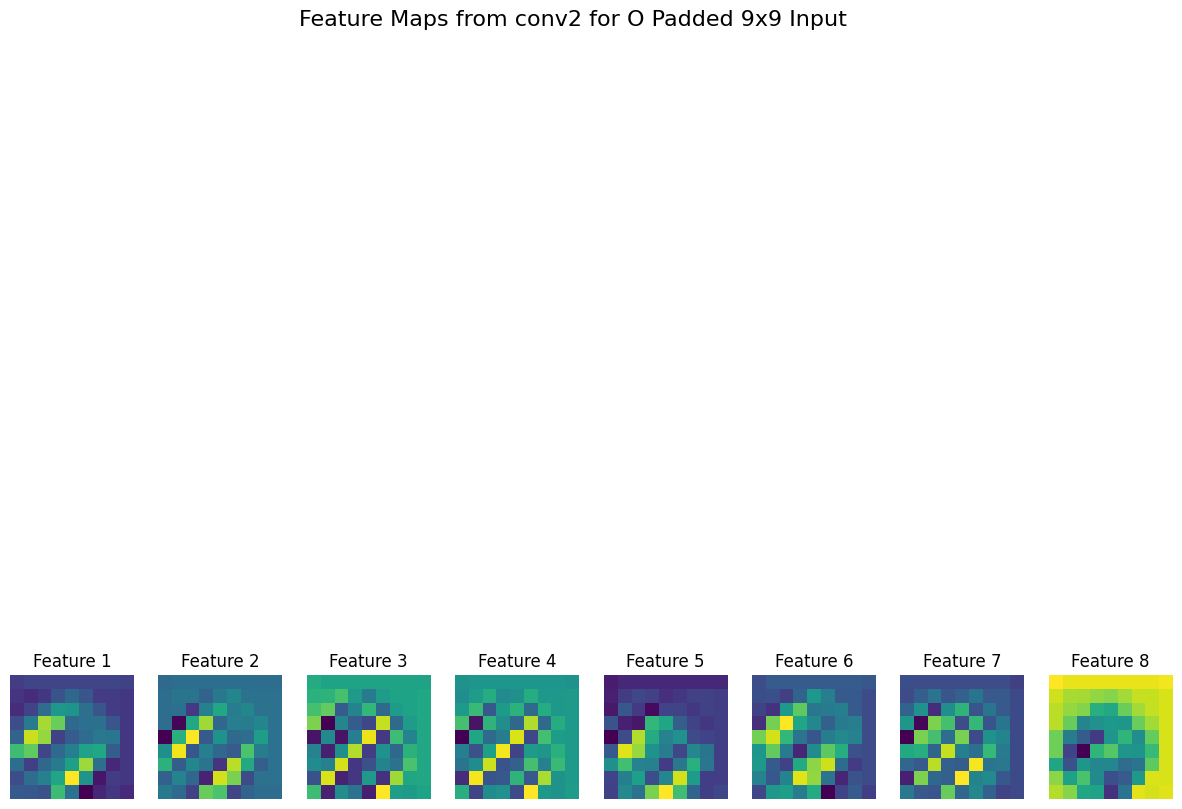

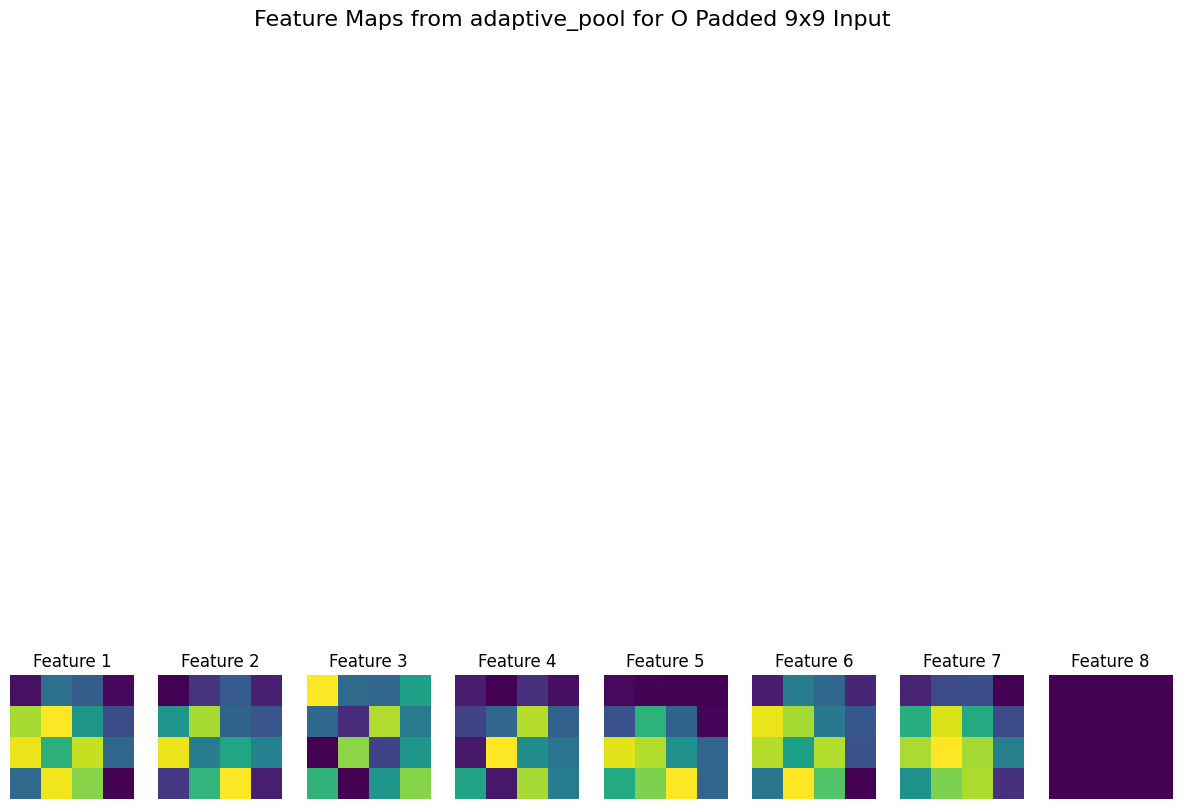

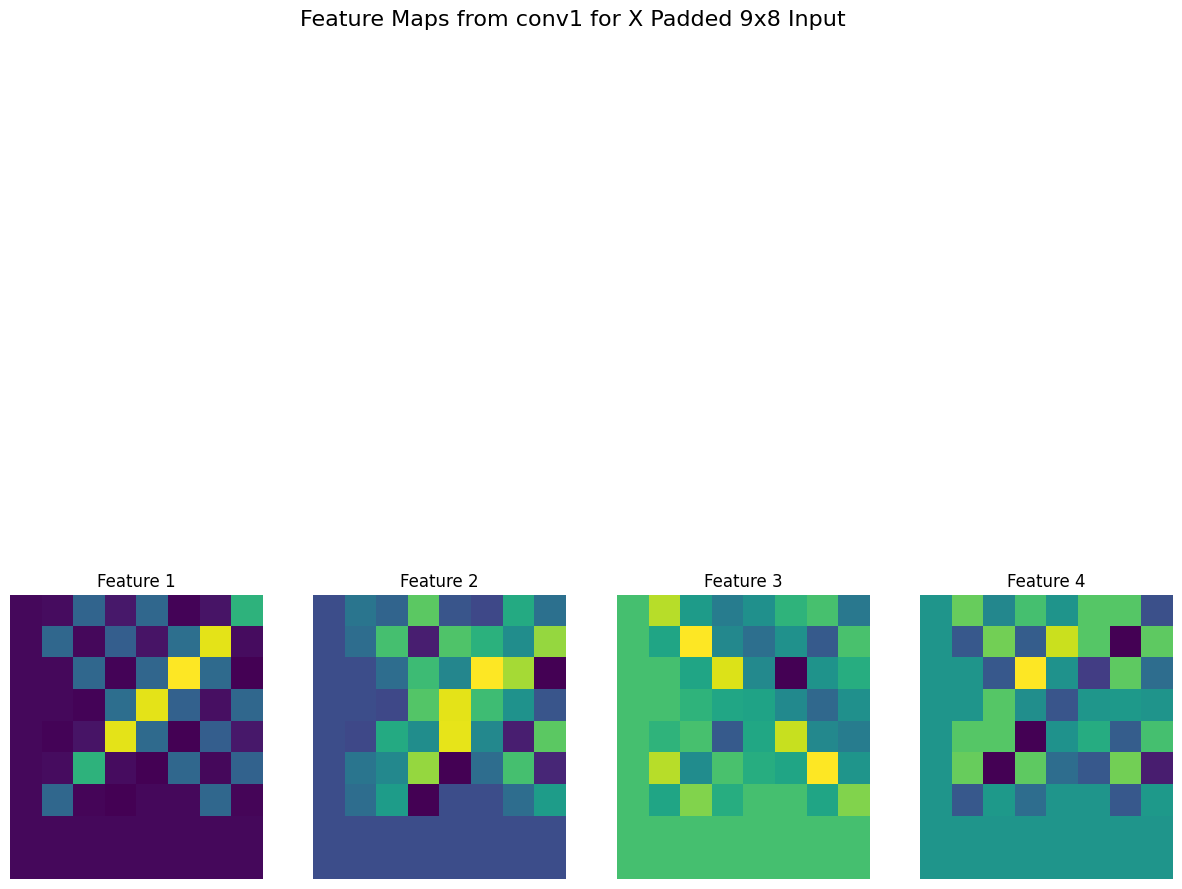

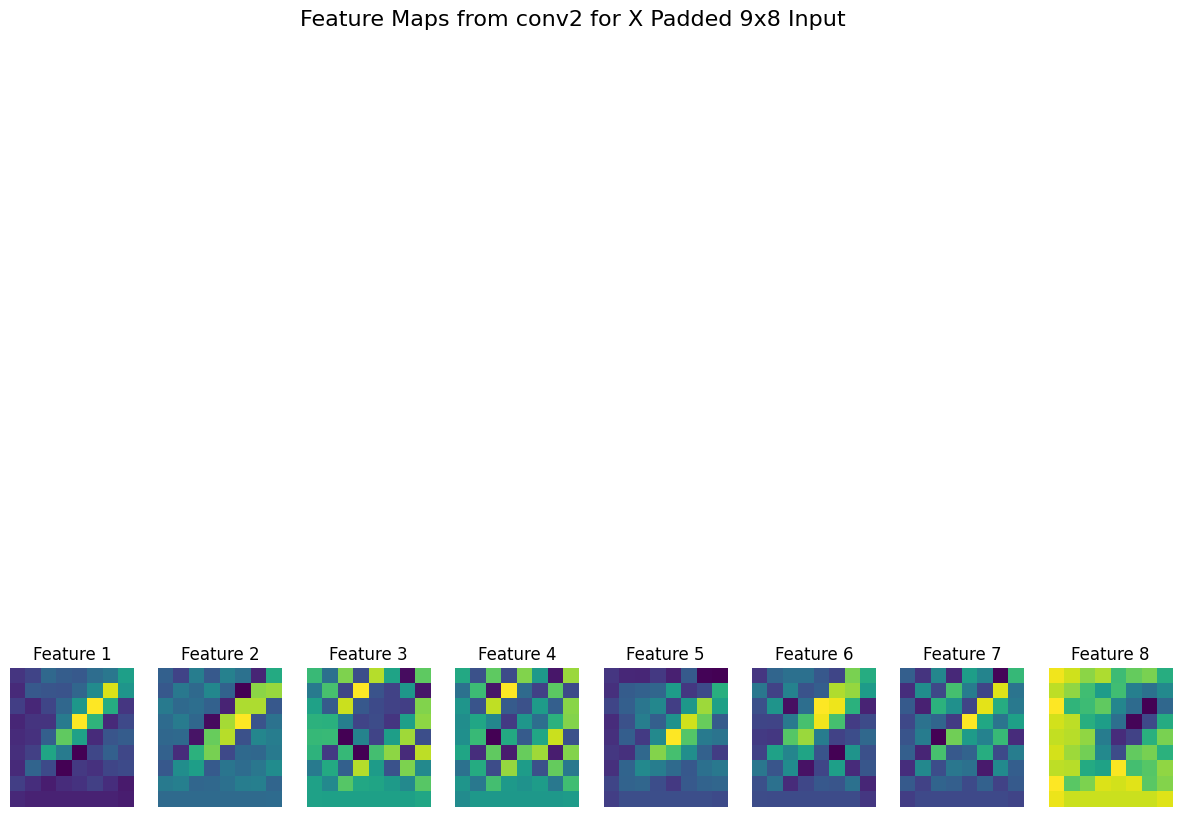

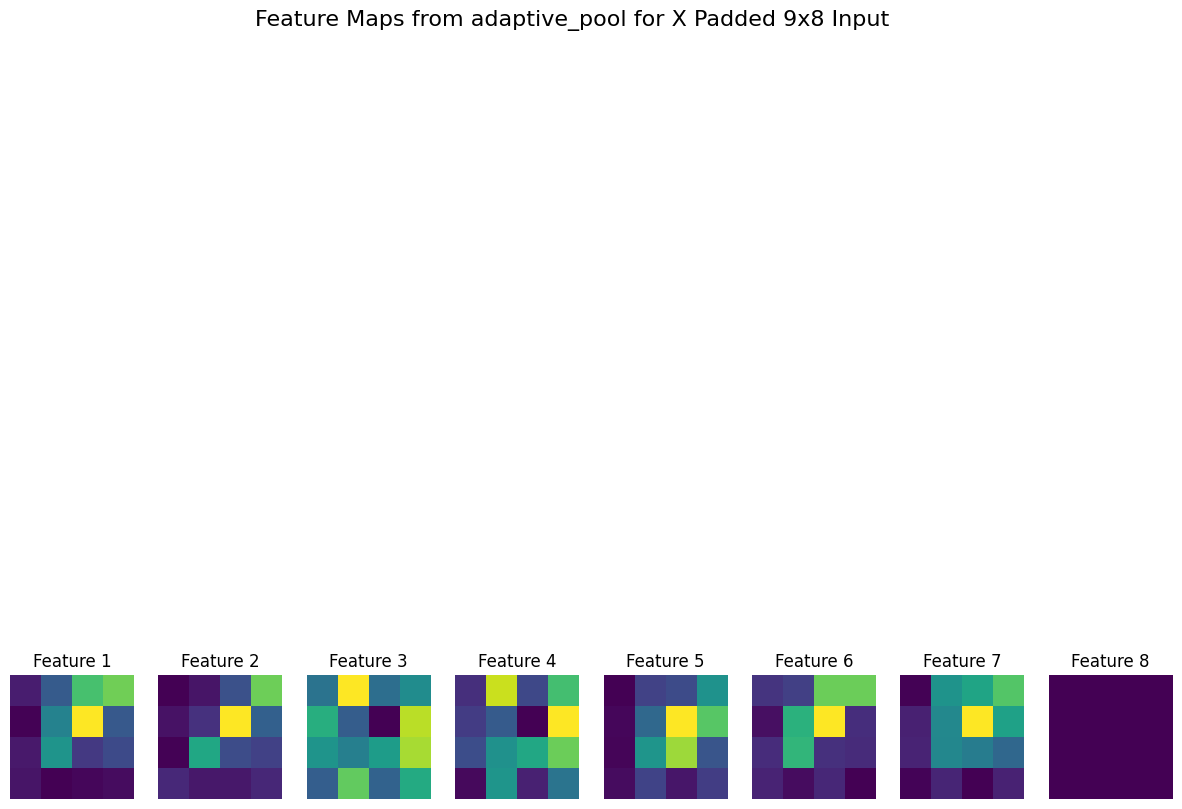

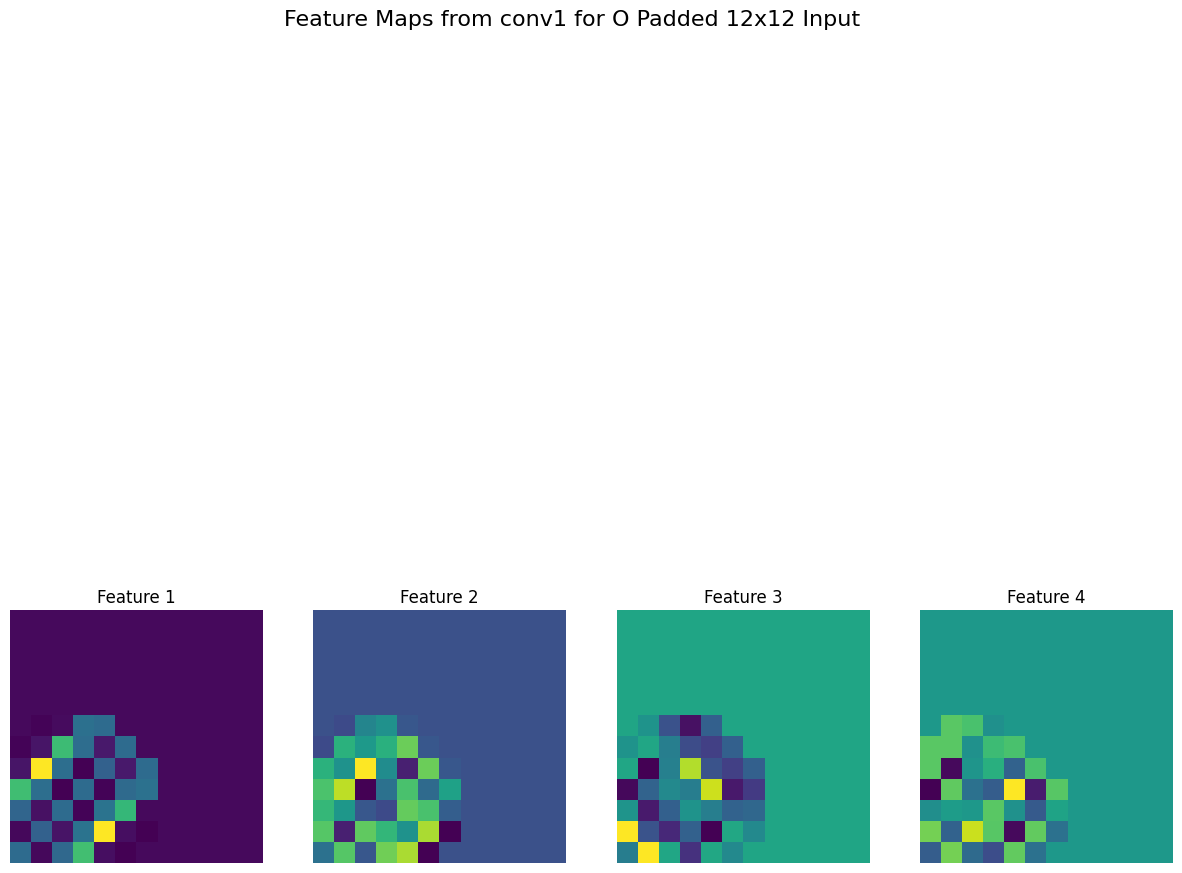

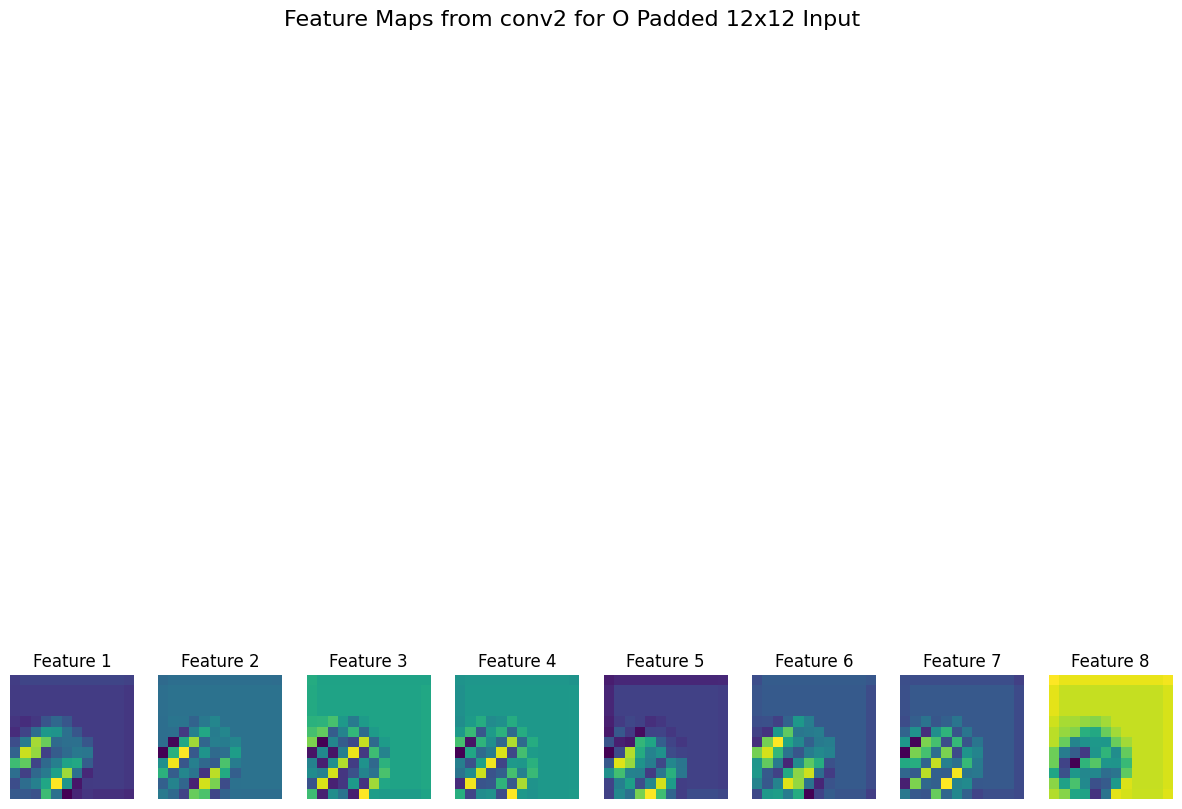

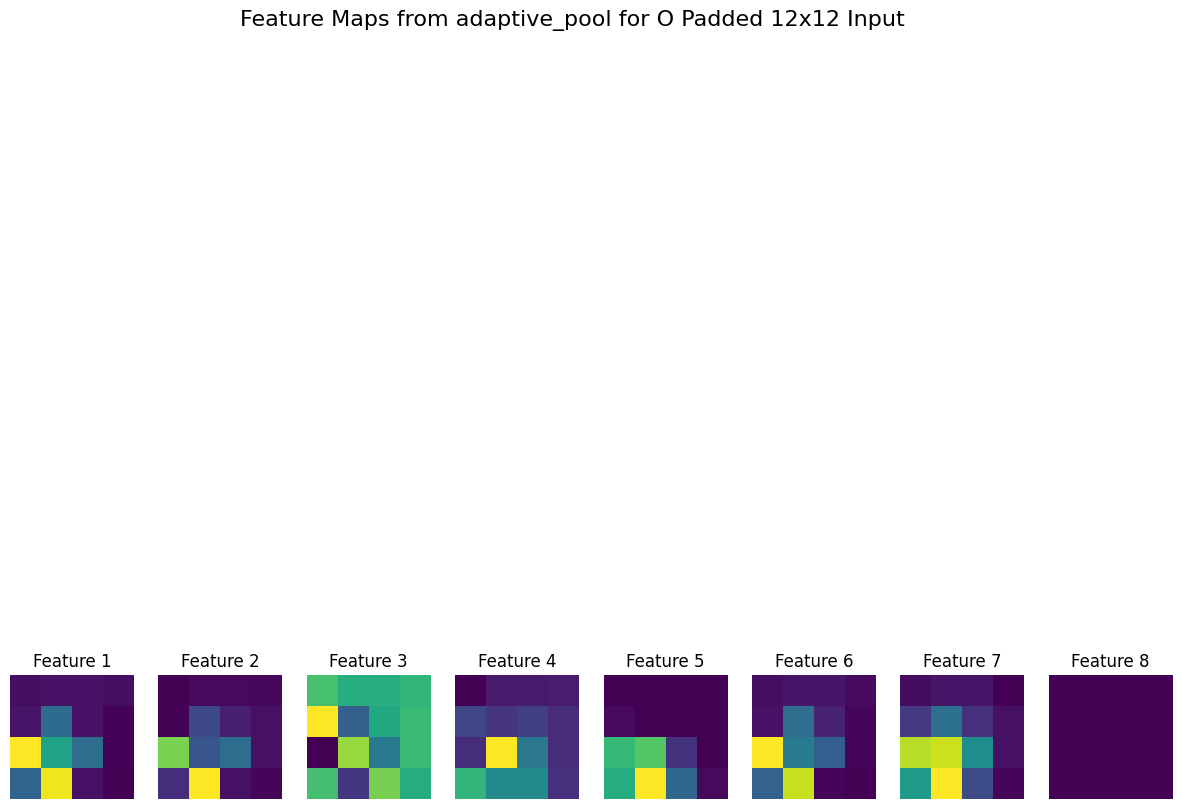

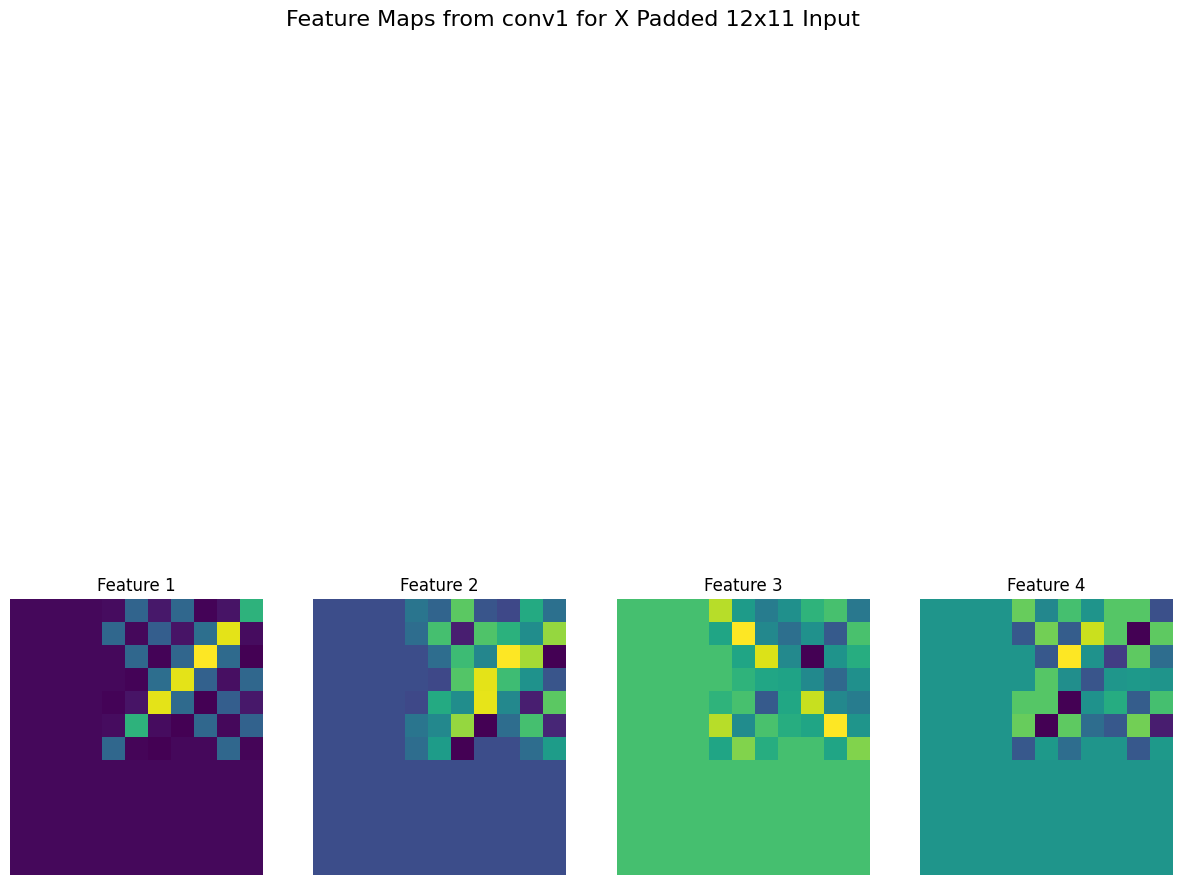

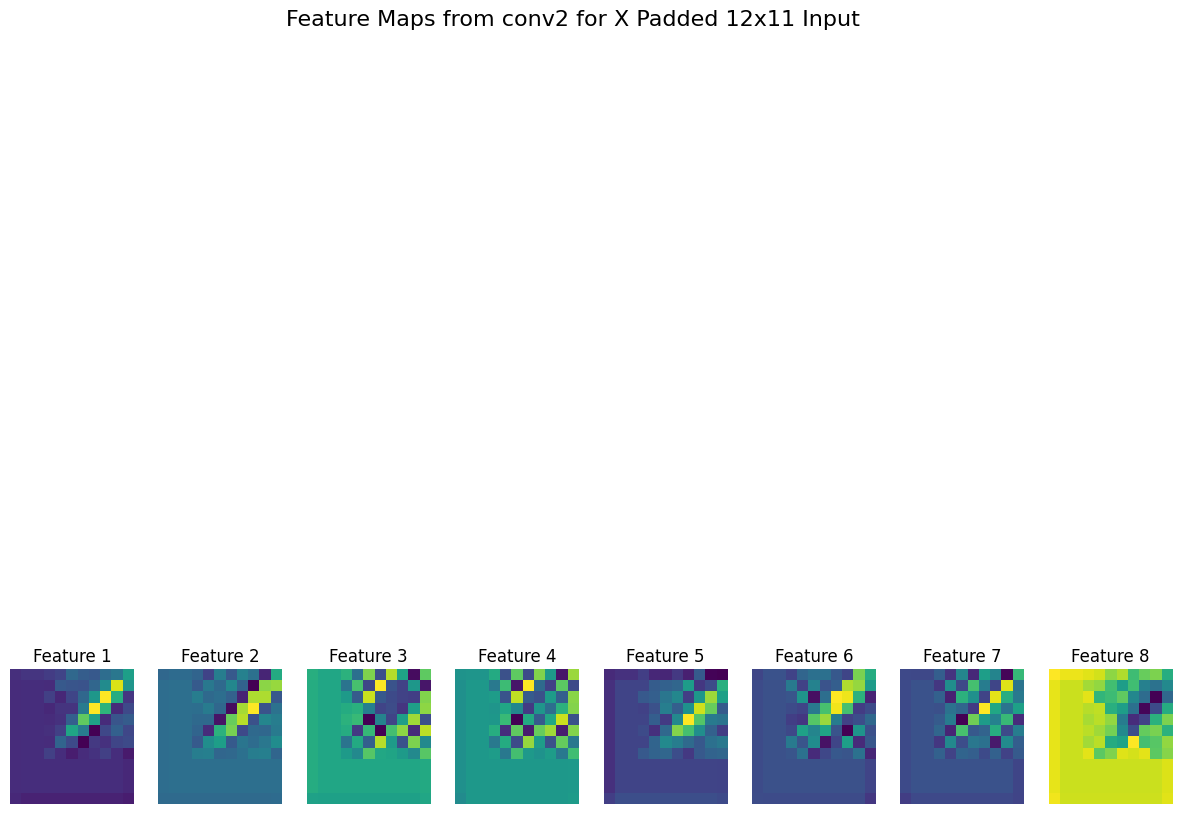

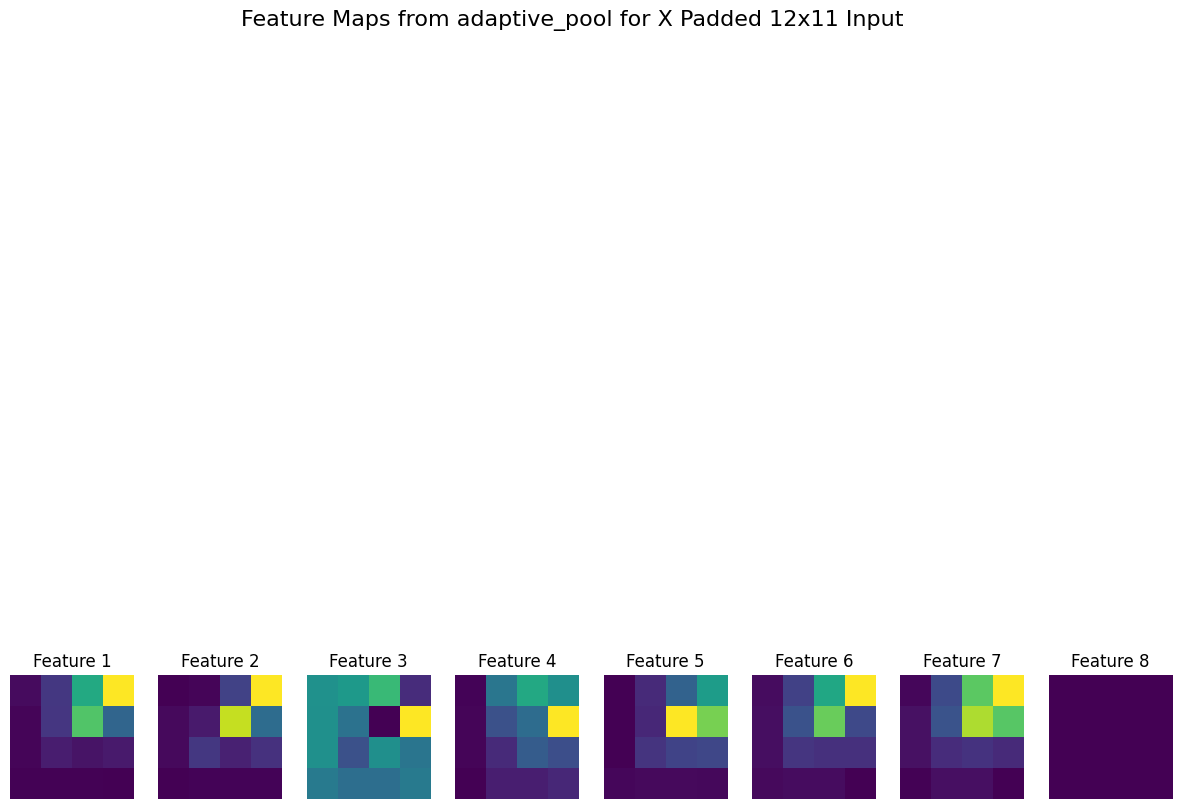

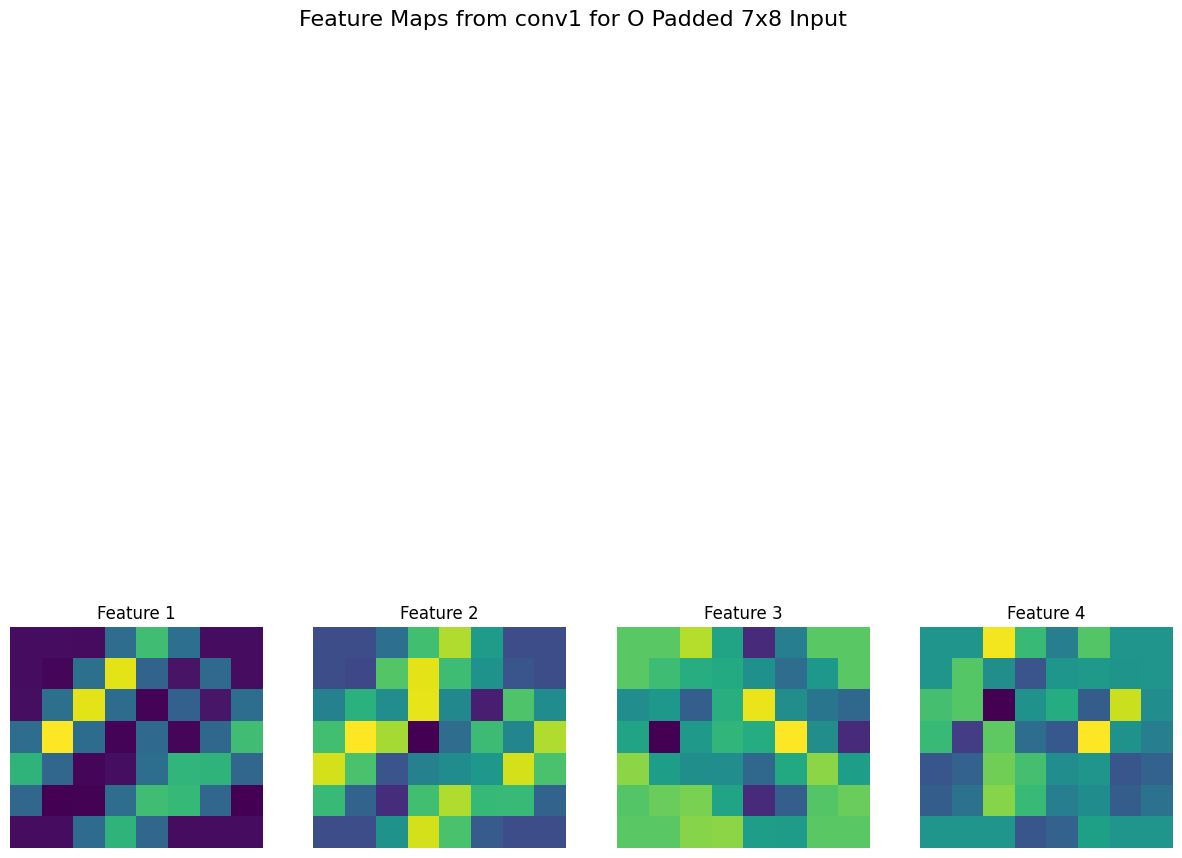

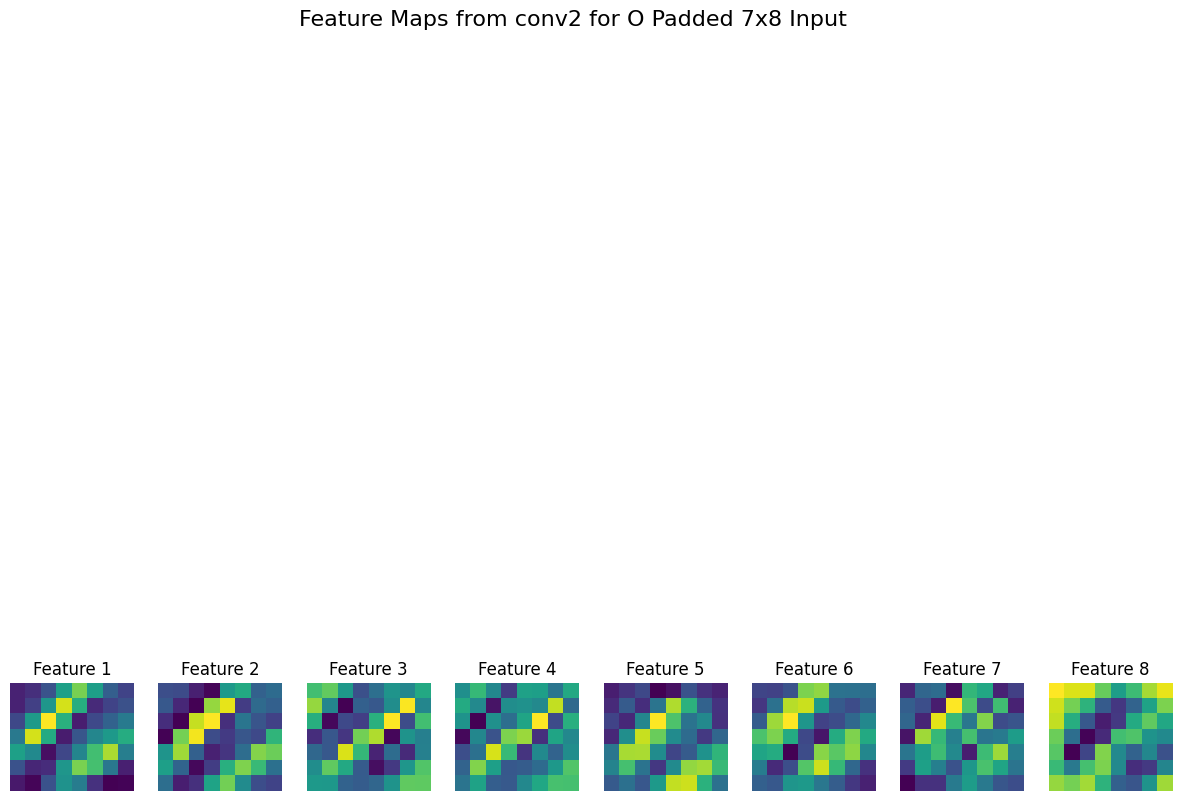

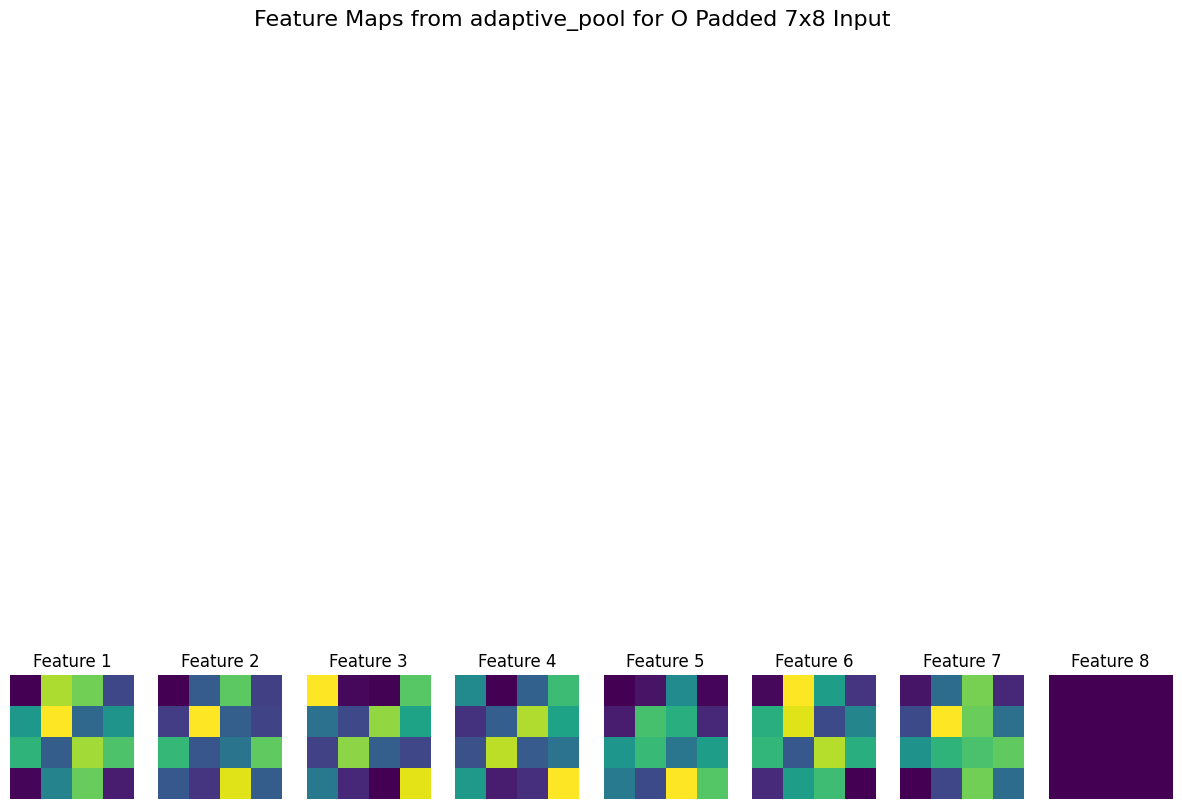

In [52]:
# Visualize feature maps (intermediate results)

for image, name in zip(test_images, test_image_names):
    _ = model(image.unsqueeze(0))  # Forward pass
    for layer in ['conv1', 'conv2', 'adaptive_pool']:
        plot_feature_maps(model.feature_maps[layer], layer, name)

Label: tensor([0]), Prediction: tensor([0])
Label: tensor([1]), Prediction: tensor([1])
Label: tensor([0]), Prediction: tensor([1])
Label: tensor([1]), Prediction: tensor([1])
Label: tensor([0]), Prediction: tensor([0])
Accuracy: 80.00%
F1 Score: 0.80


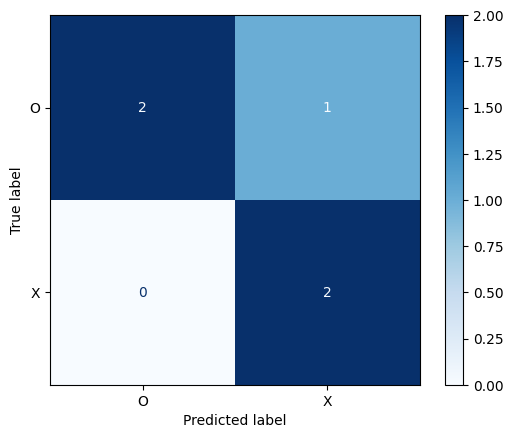

In [53]:
# perform evaluation
model.eval()
with torch.no_grad():
    for image, label in test_dataloader:
        output = model(image)
        prediction = torch.argmax(output, dim=1)
        print(f"Label: {label}, Prediction: {prediction}")

evaluate_model(model, test_dataloader)
evaluate_confusion_matrix(model, test_dataloader)